In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy  as np
import seaborn as sns
%matplotlib inline

path = './data/'
pd.options.display.max_rows = 150
pd.options.display.max_columns = 350
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

## 데이터로드

In [26]:
sigungu = pd.read_csv(path+'sigungu_imp_10.csv', encoding='cp949')
sigungu_3 = pd.read_csv(path+'시군구별지역안전지표_2015.csv', encoding='cp949')

In [27]:
y_bin = sigungu.iloc[:,-7:]    #등급(binary)
y_deci = sigungu_3.iloc[:,-7:] #등급(1-5)
X = sigungu.iloc[:,4:-7]       #독립변수X
name = sigungu.iloc[:,:4]      #이름

In [28]:
y_bin.columns = ['fire','transport','disaster','crime','accident','suicide','infection']

In [29]:
sigungu_xy = pd.concat([X,y_bin], axis=1)
sigungu_nxy = pd.concat([name, sigungu_xy,y_deci], axis=1)
sigungu_nxy.shape

(226, 162)

## 지표추가

In [30]:
#의료시설_접근가능_시설수
hop_acc = pd.read_csv(path+'의료시설_접근가능_시설수_수정(15,30).csv', encoding='cp949')
hop_acc.rename(columns={'행정구역별(1)': '시도','행정구역별(2)':'시군구'}, inplace=True)
hop_acc.shape

(246, 9)

In [31]:
##광역교통시설_접근가능_시설수
tran_acc = pd.read_csv(path+'광역교통시설_접근가능_시설수_수정.csv', encoding='cp949')
tran_acc.rename(columns={'행정구역별(1)': '시도','행정구역별(2)':'시군구'},  inplace=True)
tran_acc.shape

(246, 12)

In [32]:
##원본 데이터에서 쓸 열들만 정리
sigungu_1 = sigungu_nxy.loc[:,['시도','시군구','지역','1인가구수','고령인구수','시가화율',
                               '자살 사망자수','주민등록인구','주민등록인구(60세이상)',
                               '독거노인수','반지하가구 수','우울감경험률','suicide','자살']]
sigungu_1.shape

(226, 14)

In [33]:
sigungu_ht=sigungu_1.merge(hop_acc , on=['시도','시군구']).merge(tran_acc, on=['시도','시군구'])
sigungu_ht.shape

(226, 31)

# -함수선언
### 중앙선그리는 함수
scatter(x="이혼건수", y="5대범죄 발생건수", color="crime", df=sigungu_nxy, medianline=1, text=1, palette='picnic', hovername='지역')

In [34]:
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
def scatter(x, y, color, df, hovername=None,text=False, medianline=False, palette=['dimgrey','mediumorchid'], trendline=None):
    #산점도------
    if text == True:
        fig = px.scatter(df, x=x, y=y, text='시군구',trendline=trendline,
                             hover_name=hovername, color=color, color_discrete_sequence=palette)
        fig.update_traces(textposition='top center')
    else:
        fig = px.scatter(df, x=x, y=y,trendline=trendline,
                         hover_name=hovername, color=color, color_discrete_sequence=palette)
        fig.update_traces(textposition='top center')    
    #중앙값-----
    if medianline==True:
        #x median
        fig.add_trace(go.Scatter(x=[df[x].median()]*2,
                       y=[-10000,10000],
                       name="median x: "+str(round(df[x].median(),2)),
                       mode="lines",
                       line = dict(color = ('rgb(0,0,0)'),width=0.5),
                       visible=True,))
        #y median
        fig.add_trace(go.Scatter(x=[-10000,10000],
                       y=[df[y].median()]*2,
                       name="median y: "+str(round(df[y].median(),2)),
                       mode="lines",
                       line = dict(color = ('rgb(0,0,0)'),width=0.5),
                       visible=True))
        # 레전이동      fig.update_layout(legend=dict(x=-.05, y=1.15))
    
    #트렌드라인----
    if trendline==True:
        regline = sm.OLS(df[y],sm.add_constant(df[x])).fit().fittedvalues
        fig.add_traces(go.Scatter(x=df[x], y=regline,
                              mode = 'lines',
                              marker_color='black',
                            line = dict(color = ('rgb(0,0,0)'),width=0.5,dash='7px'),
                              name='trend all'))  
    #플롯 레이아웃(xy범위)----
    fig.update_xaxes(range=[df[x].min()*0.8, df[x].max()*1.05]) #min값 음수인지 아닌지 확인 후 범위 조절
    fig.update_yaxes(range=[df[y].min()*0.5, df[y].max()*1.05]) #min값 음수인지 아닌지 확인 후 범위 조절
    fig.show()

### 회귀식기준 위아래 갯수세기 함수
total_regression(x_='교통사고 발생건수',y_='음주교통사고 발생비율', totaldf=sigungu_nxy,groupdf=group2)

In [35]:
from scipy import stats
def total_regression(x_,y_, totaldf,groupdf):
    #전체에 대한 xy
    x = totaldf[x_].tolist()
    y = totaldf[y_].tolist()
    #전체에 대한 회귀식생성
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    #지표출력
    print(stats.linregress(x,y))
    print('Rsquared=',stats.linregress(x,y)[2]**2)
        #group에 포함되는 xy
    x = groupdf[x_].tolist()
    y = groupdf[y_].tolist()
    y_pred = []
    for i in range(len(x)):
        y_pred.append(slope*np.array(x[i])+intercept)
    upper = 0
    lower = 0
    for i in range(len(y)):
        if y[i]>=y_pred[i]:
            upper +=1
        else:
            lower +=1
    return pd.DataFrame({'':['total','upper','lower'],
                          'count':[len(y),upper,lower],
                          'ratio':[len(y)/len(y), upper/len(y), lower/len(y)]})

### 회귀식기준 위아래 갯수세기 함수
con_check(독립변수집단, 비교할 결과값, 넣을 데이터, 집단1, 집단2)

In [36]:
# 연속형 변수 중에 DI1_pr에 따라 평균이 다른 변수만 추출
import matplotlib.pyplot as plt
import seaborn as sns # plt, sns는 그림을 그리기 위함
import scipy.stats as stats # t-test를 하기 위함

def con_check(var1, var2, data, group1, group2): # var1에는 질병에 관한 변수, var2는 연속형 변수들, data는 확인할 dataframe
    g1 = group1
    g2 = group2
    var1_0 = data.loc[data[var1] == 0][var2] # var1==0인 경우의 var2값
    var1_1 = data.loc[data[var1] == 1][var2] # var1==1인 경우의 var2값
    g = sns.distplot(var1_0, label = g1)
    g = sns.distplot(var1_1, label = g2) #각 경우의 분포 그래프 그리기
    g.legend()
    plt.show()
    
    
    # t-test하기 전에 먼저 두 집단의 var2변수가 등분산을 충족하는지 검정
    # H0(귀무가설) : 두 모집단의 분산은 같다
    # H1(대립가설) : 두 모집단의 분산은 다르다
    equal_variance=stats.levene(var1_0, var1_1)
    print('등분산 검정에 대한 p-value : %s'%equal_variance[1]) # 등분산 검정에 대한 p-value
    
    
    # 독립표본 T검정
    #H0(귀무가설) : var1에 따른 var2의 평균에 차이가 없다
    #H1(대립가설) : var1에 따른 var2의 평균에 차이가 있다
     
    
    # 등분산 검정에 대한 p-value가 0.05보다 작은 경우, H0를 기각하므로 두 모집단의 분산은 다른다
    if equal_variance[1] < 0.05:
        print('등분산 검정에 대한 p-value가 0.05보다 작다')
        # 두 모집단의 분산이 다른 경우, equal_var=False로 놓고 독립표본 t-검정 진행
        t = stats.ttest_ind(var1_0, var1_1, equal_var=False)
        print('t-test에 대한 p-vlaue : %s'%t[1])
        if t[1] < 0.05:
            print('T-test에 대한 p-value가 0.05보다 작으므로 HO를 기각한다★')
            print(f'{g1}집단 평균:',var1_0.mean(),'\n',f'{g2}집단 평균:',var1_1.mean())
            return var2
        else:
            print('T-test에 대한 p-value가 0.05보다 크므로 HO를 채택')
                   
    # 등분산 검정에 대한 p-value가 0.05보다 큰 경우, H0를 채택하므로 두 모집단의 분산은 같다.
    else: 
        # 두 모집단의 분산이 같은 경우, equal_var=True로 놓고 독립표본 t-검정 진행
        t = stats.ttest_ind(var1_0, var1_1, equal_var=True)
        print('t-test에 대한 p-vlaue : %s'%t[1])
        
        if t[1] < 0.05:
            print('T-test에 대한 p-value가 0.05보다 작으므로 HO를 기각한다★')
            print(f'{g1}집단 평균:',var1_0.mean(),'\n',f'{g2}집단 평균:',var1_1.mean())
        else:
            print('T-test에 대한 p-value가 0.05보다 크므로 HO를 채택')

# -가설설정
### 반지하 가구수가 많은 지역은 교통 인프라가 좋을것이고 이는 노인활동범위를 늘어나게 함으로써 자살률에 영향을 미칠 것이다.
<pre>
1. 반지하가구수가 많은 동네는 도시화되 된 지역일 것이다.
2. 의료+교통인프라가 좋은 곳은 노인활동범위를 늘어나게 할것이다.
3. 노인활동범위가 늘어난다면 자살률일 줄어들것이다.
</pre>
# -가설검증


### 사실검증

## 1. 반지하가구수가 많은 동네는 도시화되 된 지역일 것이다.

In [37]:
a = sigungu_nxy.corr(method='pearson')['반지하가구 수']

In [38]:
pd.DataFrame(a).loc[pd.DataFrame(a)['반지하가구 수']>0.55,:]

,반지하가구 수
건축용지 면적,0.617274
도로면적,0.589122
도로면적 비율,0.589119
도시지역 면적,0.551899
도시지역 면적 비율,0.551899
반지하가구 수,1.000000
시가화율,0.626183
실업률,0.609154
인구밀도,0.776850
주거지역 면적,0.725136


## 가설검증 1

### 반지하가구수와, 시가화율이 높은 동네는 의료 인프라, 교통 인프라, 재정자주도가 좋을 것이다.

In [39]:
sigungu_ht['의료 인프라'] = sigungu_ht['공공의료시설(15분)'] + sigungu_ht['공공의료시설(30분)']\
+sigungu_ht['종합병원(15분)'] + sigungu_ht['종합병원(30분)']

In [40]:
sigungu_ht['suicide_']=sigungu_ht.suicide.astype(str)
sigungu_ht.head()

,시도,시군구,지역,1인가구수,고령인구수,시가화율,자살 사망자수,주민등록인구,주민등록인구(60세이상),독거노인수,반지하가구 수,우울감경험률,suicide,자살,시간대별(1),공공의료시설(15분),공공의료시설(30분),병_의원(15분),병_의원(30분),종합병원(15분),종합병원(30분),버스터미널(15분),버스터미널(30분),버스터미널(45분),철도역(15분),철도역(30분),철도역(45분),공항(15분),공항(30분),공항(45분),공항(60분),의료 인프라,suicide_
0,강원도,강릉시,2015_강원도_강릉시,1161.45445,1668.57424,2.25,3.66068,215807.0,2266.60859,404.29643,22.52012,4.7,1,4,일평균(06-20시),0.19,1.08,6.18,10.00,0.37,1.82,0.33,1.20,2.03,0.17,0.68,0.95,0.0,0.0,0.0,0.04,3.46,1
1,강원도,고성군,2015_강원도_고성군,1019.52493,2275.59549,0.54,3.63408,30269.0,2948.56123,560.63960,4.95557,3.9,0,3,일평균(06-20시),0.75,1.94,1.42,4.52,0.01,0.23,0.40,0.89,1.93,0.00,0.00,0.00,0.0,0.0,0.0,0.07,2.93,0
2,강원도,동해시,2015_강원도_동해시,922.56932,1528.73247,13.31,4.44153,94562.0,2116.70650,384.82689,3.48977,8.5,1,4,일평균(06-20시),0.31,0.95,7.35,10.00,0.30,0.63,0.52,1.24,2.68,0.23,0.95,1.49,0.0,0.0,0.0,0.00,2.19,1
3,강원도,삼척시,2015_강원도_삼척시,1204.60768,1969.88135,1.43,4.28686,72314.0,2602.95378,580.93868,8.43543,6.5,1,5,일평균(06-20시),0.50,1.05,3.75,7.70,0.27,0.60,0.64,1.26,1.88,0.07,0.18,0.41,0.0,0.0,0.0,0.00,2.42,1
4,강원도,속초시,2015_강원도_속초시,1063.66460,1487.40780,9.02,4.00330,82432.0,2044.47302,393.41518,10.43284,10.7,1,4,일평균(06-20시),0.67,1.97,9.93,10.00,0.66,1.76,0.64,1.88,2.57,0.00,0.00,0.00,0.0,0.0,0.0,0.98,5.06,1


In [45]:
scatter(x="반지하가구 수", y="시가화율", color="suicide_", df=sigungu_ht,
        medianline=True, hovername='지역')

In [42]:
scatter(x="반지하가구 수", y="공공의료시설(30분)", color="suicide", df=sigungu_ht,
        medianline=True, hovername='지역', palette='fall')

In [43]:
#2)데이터프레임의 새로운 열을 만들어 타겟팅 그룹을 구분한다.
#1사분면의 모든 주황초록점 : group1, 1사분면 주황점: group2
sigungu_ht['group1'] = np.zeros(len(sigungu_ht))
sigungu_ht['group2'] = np.zeros(len(sigungu_ht))
#조건을 만족하는 행 인덱스 가져오기
cond = (sigungu_ht['시가화율']>sigungu_ht['시가화율'].median())&((sigungu_ht['반지하가구 수']>sigungu_ht['반지하가구 수'].median()))
group1_index = sigungu_ht.loc[cond].index
group2_index = sigungu_ht.loc[~(cond)].index
#group1에 속하는 애들을 1로 표시
sigungu_ht['group1']= 0
sigungu_ht.loc[sigungu_ht.index.isin(group1_index),'group1'] = 1
sigungu_ht.loc[sigungu_ht.index.isin(group2_index),'group2'] = 1

In [23]:
sigungu_ht.head(1)

,시도,시군구,지역,1인가구수,고령인구수,시가화율,자살 사망자수,주민등록인구,주민등록인구(60세이상),독거노인수,반지하가구 수,우울감경험률,suicide,자살,시간대별(1),공공의료시설(15분),공공의료시설(30분),병_의원(15분),병_의원(30분),종합병원(15분),종합병원(30분),버스터미널(15분),버스터미널(30분),버스터미널(45분),철도역(15분),철도역(30분),철도역(45분),공항(15분),공항(30분),공항(45분),공항(60분),의료 인프라,suicide_,group1,group2
0,강원도,강릉시,2015_강원도_강릉시,1161.45445,1668.57424,2.25,3.66068,215807.0,2266.60859,404.29643,22.52012,4.7,1,4,일평균(06-20시),0.19,1.08,6.18,10.0,0.37,1.82,0.33,1.2,2.03,0.17,0.68,0.95,0.0,0.0,0.0,0.04,3.46,1,0,1.0


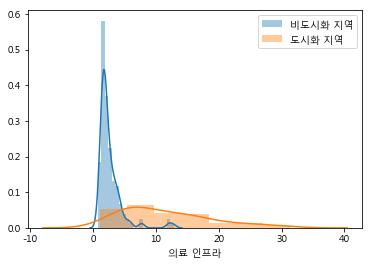

등분산 검정에 대한 p-value : 1.8134763617034158e-21
등분산 검정에 대한 p-value가 0.05보다 작다
t-test에 대한 p-vlaue : 9.123360206164452e-20
T-test에 대한 p-value가 0.05보다 작으므로 HO를 기각한다★
비도시화 지역집단 평균: 2.6436956521739137 
 도시화 지역집단 평균: 11.476590909090909


'의료 인프라'

In [24]:
con_check('group1', '의료 인프라', sigungu_ht, '비도시화 지역', '도시화 지역')

In [16]:
sigungu_ht['group'] = 0

In [17]:
sigungu_ht.loc[((sigungu_ht['반지하가구 수'])>(sigungu_ht['반지하가구 수'].mean())),'group'] = 1

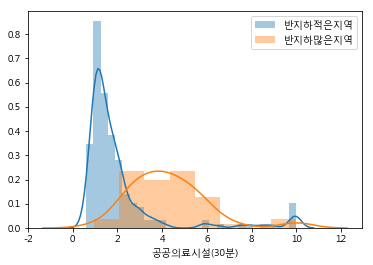

등분산 검정에 대한 p-value : 0.29068585688709203
t-test에 대한 p-vlaue : 2.5726136447849943e-11
T-test에 대한 p-value가 0.05보다 작으므로 HO를 기각한다★
반지하적은지역집단 평균: 2.073220338983052 
 반지하많은지역집단 평균: 4.271020408163265


In [18]:
con_check('group', '공공의료시설(30분)', sigungu_ht, '반지하적은지역', '반지하많은지역')

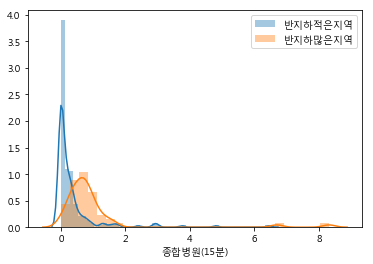

등분산 검정에 대한 p-value : 0.16419085184889853
t-test에 대한 p-vlaue : 0.00015931669484497163
T-test에 대한 p-value가 0.05보다 작으므로 HO를 기각한다★
반지하적은지역집단 평균: 0.36225988700564976 
 반지하많은지역집단 평균: 0.9673469387755101


In [19]:
con_check('group', '종합병원(15분)', sigungu_ht, '반지하적은지역', '반지하많은지역')

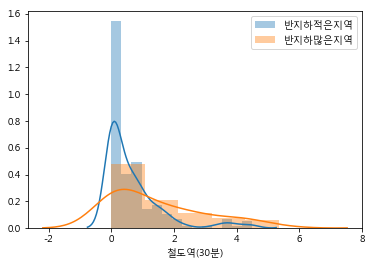

등분산 검정에 대한 p-value : 2.13717007152553e-05
등분산 검정에 대한 p-value가 0.05보다 작다
t-test에 대한 p-vlaue : 0.0012682192670737792
T-test에 대한 p-value가 0.05보다 작으므로 HO를 기각한다★
반지하적은지역집단 평균: 0.6679096045197742 
 반지하많은지역집단 평균: 1.4312244897959185


'철도역(30분)'

In [20]:
con_check('group', '철도역(30분)', sigungu_ht, '반지하적은지역', '반지하많은지역')

In [21]:
sigungu_ht['노인비율'] = sigungu_ht['주민등록인구']/sigungu_ht['주민등록인구(60세이상)']

In [22]:
sigungu_ht

,시도,시군구,지역,1인가구수,고령인구수,자살 사망자수,주민등록인구,주민등록인구(60세이상),독거노인수,반지하가구 수,우울감경험률,suicide,자살,시간대별(1),공공의료시설(15분),공공의료시설(30분),병_의원(15분),병_의원(30분),종합병원(15분),종합병원(30분),버스터미널(15분),버스터미널(30분),버스터미널(45분),철도역(15분),철도역(30분),철도역(45분),공항(15분),공항(30분),공항(45분),공항(60분),group,노인비율
0,강원도,강릉시,2015_강원도_강릉시,1161.45445,1668.57424,3.66068,215807.0,2266.60859,404.29643,22.52012,4.7,1,4,일평균(06-20시),0.19,1.08,6.18,10.00,0.37,1.82,0.33,1.20,2.03,0.17,0.68,0.95,0.0,0.00,0.00,0.04,0,95.211410
1,강원도,고성군,2015_강원도_고성군,1019.52493,2275.59549,3.63408,30269.0,2948.56123,560.63960,4.95557,3.9,0,3,일평균(06-20시),0.75,1.94,1.42,4.52,0.01,0.23,0.40,0.89,1.93,0.00,0.00,0.00,0.0,0.00,0.00,0.07,0,10.265685
2,강원도,동해시,2015_강원도_동해시,922.56932,1528.73247,4.44153,94562.0,2116.70650,384.82689,3.48977,8.5,1,4,일평균(06-20시),0.31,0.95,7.35,10.00,0.30,0.63,0.52,1.24,2.68,0.23,0.95,1.49,0.0,0.00,0.00,0.00,0,44.674120
3,강원도,삼척시,2015_강원도_삼척시,1204.60768,1969.88135,4.28686,72314.0,2602.95378,580.93868,8.43543,6.5,1,5,일평균(06-20시),0.50,1.05,3.75,7.70,0.27,0.60,0.64,1.26,1.88,0.07,0.18,0.41,0.0,0.00,0.00,0.00,0,27.781515
4,강원도,속초시,2015_강원도_속초시,1063.66460,1487.40780,4.00330,82432.0,2044.47302,393.41518,10.43284,10.7,1,4,일평균(06-20시),0.67,1.97,9.93,10.00,0.66,1.76,0.64,1.88,2.57,0.00,0.00,0.00,0.0,0.00,0.00,0.98,0,40.319436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,충청북도,제천시,2015_충청북도_제천시,997.25887,1684.73375,4.09342,136805.0,2327.47341,399.98538,5.99393,6.6,1,5,일평균(06-20시),0.28,0.91,9.56,10.00,0.20,0.92,0.49,1.49,1.71,0.19,0.64,0.88,0.0,0.00,0.00,0.00,0,58.778330
222,충청북도,증평군,2015_충청북도_증평군,865.37632,1424.17532,2.58836,34771.0,1940.12252,339.93845,1.72558,8.7,0,1,일평균(06-20시),0.28,3.38,8.13,10.00,0.00,0.01,0.64,0.91,1.01,0.41,0.88,1.52,0.0,0.02,0.52,0.93,0,17.922064
223,충청북도,진천군,2015_충청북도_진천군,898.51781,1633.78034,3.83589,65174.0,2189.06312,378.98549,4.29619,3.3,0,2,일평균(06-20시),0.50,1.84,3.71,7.65,0.19,0.39,0.22,0.55,0.86,0.00,0.00,0.12,0.0,0.00,0.02,0.34,0,29.772554
224,충청북도,청주시,2015_충청북도_청주시,926.51899,1034.82654,2.47739,831521.0,1464.85777,211.99705,15.30929,9.0,0,2,일평균(06-20시),0.22,2.01,10.00,10.00,0.45,2.34,0.21,0.78,1.90,0.02,0.25,1.26,0.0,0.04,0.21,0.96,0,567.646236


In [23]:
scatter(x="주민등록인구(60세이상)", y="자살 사망자수", color="suicide", df=sigungu_ht,
        medianline=True, hovername='지역', palette='fall')

C:\Users\COM\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.

